### Imports

We will use a familiar stack of data science and machine learning libraries.

In [11]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale=2)

# Imputing missing values and scaling values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree

# LIME for explaining predictions
import lime
import lime.lime_tabular


### Read in Data

In [12]:
# Read in data into dataframes
train_features = pd.read_csv('../data/training_features_cleaned.csv')
test_features = pd.read_csv('../data/testing_features_cleaned.csv')
train_labels = pd.read_csv('../data/training_labels_cleaned.csv')
test_labels = pd.read_csv('../data/testing_labels_cleaned.csv')

## Recreate Final Model

In [13]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training features
imputer.fit(train_features)

# Transform both training and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn expects the labels as one-dimensional arrays
y = train_labels.values.ravel()
y_test = test_labels.values.ravel()


In [14]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the Gradient Boosting model with updated parameters
model = GradientBoostingRegressor(
    loss='absolute_error',
    max_depth=5,
    max_features=None,
    min_samples_leaf=6,
    min_samples_split=6,
    n_estimators=800,
    random_state=42
)

# Fit the model on the training data
model.fit(X, y)


GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                          min_samples_leaf=6, min_samples_split=6,
                          n_estimators=800, random_state=42)

In [16]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 1.8113


# Interprete the Model

Machine learning is often [criticized as being a black-box](https://www.technologyreview.com/s/604087/the-dark-secret-at-the-heart-of-ai/): we put data in on one side and it gives us the answers on the other. While these answers are often extremely accurate, the model tells us nothing about how it actually made the predictions. This is true to some extent, but there are ways in which we can try and discover how a model "thinks" such as the [Locally Interpretable Model-agnostic Explainer (LIME)](https://arxiv.org/pdf/1602.04938.pdf). This attemps to explain model predictions by learning a linear regression around the prediction, which is an easily interpretable model!

We will explore several ways to interpret our model:

* Feature importances
* Locally Interpretable Model-agnostic Explainer (LIME)
* Examining a single decision tree in the ensemble.

## Feature Importances

One of the basic ways we can interpret an ensemble of decision trees is through what are known as the feature importances. These can be interpreted as the variables which are most predictive of the target. While the actual details of the feature importances are quite complex ([here is a Stack Overflow question on the subject](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined), we can use the relative values to compare the features and determine which are most relevant to our problem. 

Extracting the feature importances from a trained ensemble of trees is quite easy in scikit-learn. We will store the feature importances in a dataframe to analyze and visualize them.

In [17]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.511094
1,National Median Site EUI (kBtu/ft²),0.182389
2,Largest Property Use Type_Multifamily Housing,0.111938
3,Electricity - Weather Normalized Site Electric...,0.053363
4,log_Largest Property Use Type - Gross Floor Ar...,0.014587
5,Longitude,0.011518
6,Year Built,0.011033
7,log_Natural Gas Use (kBtu),0.010685
8,Latitude,0.010353
9,Census Tract (2020),0.010233


The Site Energy Use Intensity, `Site EUI (kBtu/ft²)`, and the Weather Normalized Site Electricity Intensity, `Weather Normalized Site Electricity Intensity (kWh/ft²)` are the two most important features by quite a large margin. After that, the relative importance drops off considerably which indicates that we might not need to retain all of the features to create a model with nearly the same performance.

Let's graph the feature importances to compare visually.

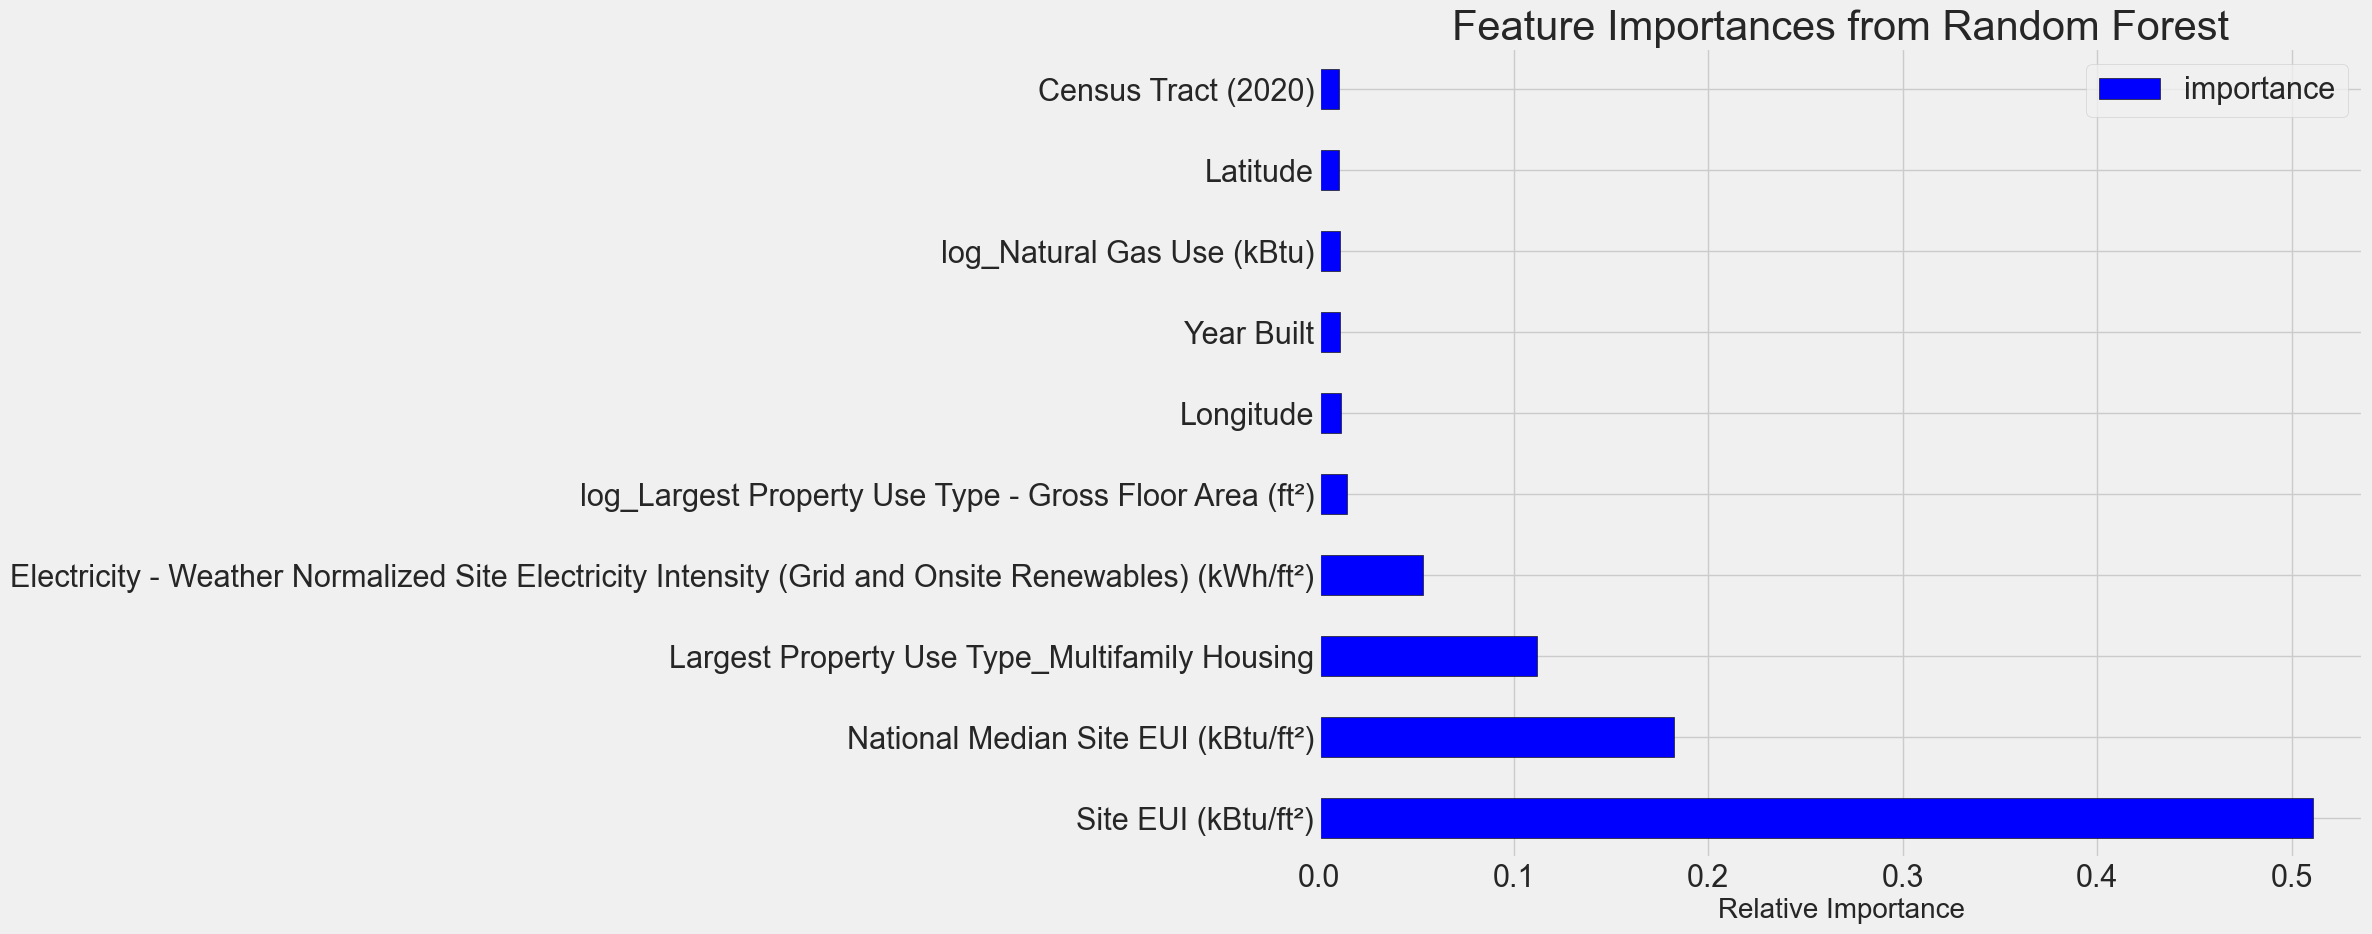

In [18]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

## Use Feature Importances for Feature Selection

Given that not every feature is important for finding the score, what would happen if we used a simpler model, such as a linear regression, with the subset of most important features from the random forest? The linear regression did outperform the baseline, but it did not perform well compared to the model complex models. Let's try using only the 10 most important features in the linear regression to see if performance is improved. We can also limit to these features and re-evaluate the random forest.

In [23]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (5794, 10)
Most important testing  features shape:  (2484, 10)


In [24]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    10.3652.
Linear Regression Reduced Results: MAE = 10.8196.


Well, reducing the features did not improve the linear regression results! It turns out that the extra information in the features with low importance do actually improve performance. 

Let's look at using the reduced set of features in the gradient boosted regressor. How is the performance affected?

In [25]:
# Create the model with corrected loss parameter
model_reduced = GradientBoostingRegressor(
    loss='absolute_error',
    max_depth=5,
    max_features=None,
    min_samples_leaf=6,
    min_samples_split=6,
    n_estimators=800,
    random_state=42
)

# Fit the model on the reduced training set
model_reduced.fit(X_reduced, y)

# Predict on the reduced test set
model_reduced_pred = model_reduced.predict(X_test_reduced)

# Evaluate and print MAE
print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))


Gradient Boosted Reduced Results: MAE = 1.8623


The model results are slightly worse with the reduced set of features and we will keep all of the features for the final model. The desire to reduce the number of features is because we are always looking to build the most [parsimonious model](http://www.statisticshowto.com/parsimonious-model/): that is, the simplest model with adequate performance. A model that uses fewer features will be faster to train and generally easier to interpret. In this case, keeping all of the features is not a major concern because the training time is not significant and we can still make interpretations with many features.

## Locally Interpretable Model-agnostic Explanations

We will look at using [LIME to explain individual predictions](https://github.com/marcotcr/lime) made the by the model. LIME is a relatively new effort aimed at showing how a machine learning model thinks by approximating the region around a prediction with a linear model.

We will look at trying to explain the predictions on an example the model gets very wrong and an example the model gets correct. We will restrict ourselves to using the reduced set of 10 features to aid interpretability. The model trained on the 10 most important features is slightly less accurate, but we generally have to trade off accuracy for interpretability!

In [26]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [27]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_5264/2438247814.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))


Prediction: 32.2222
Actual Value: 15.0000


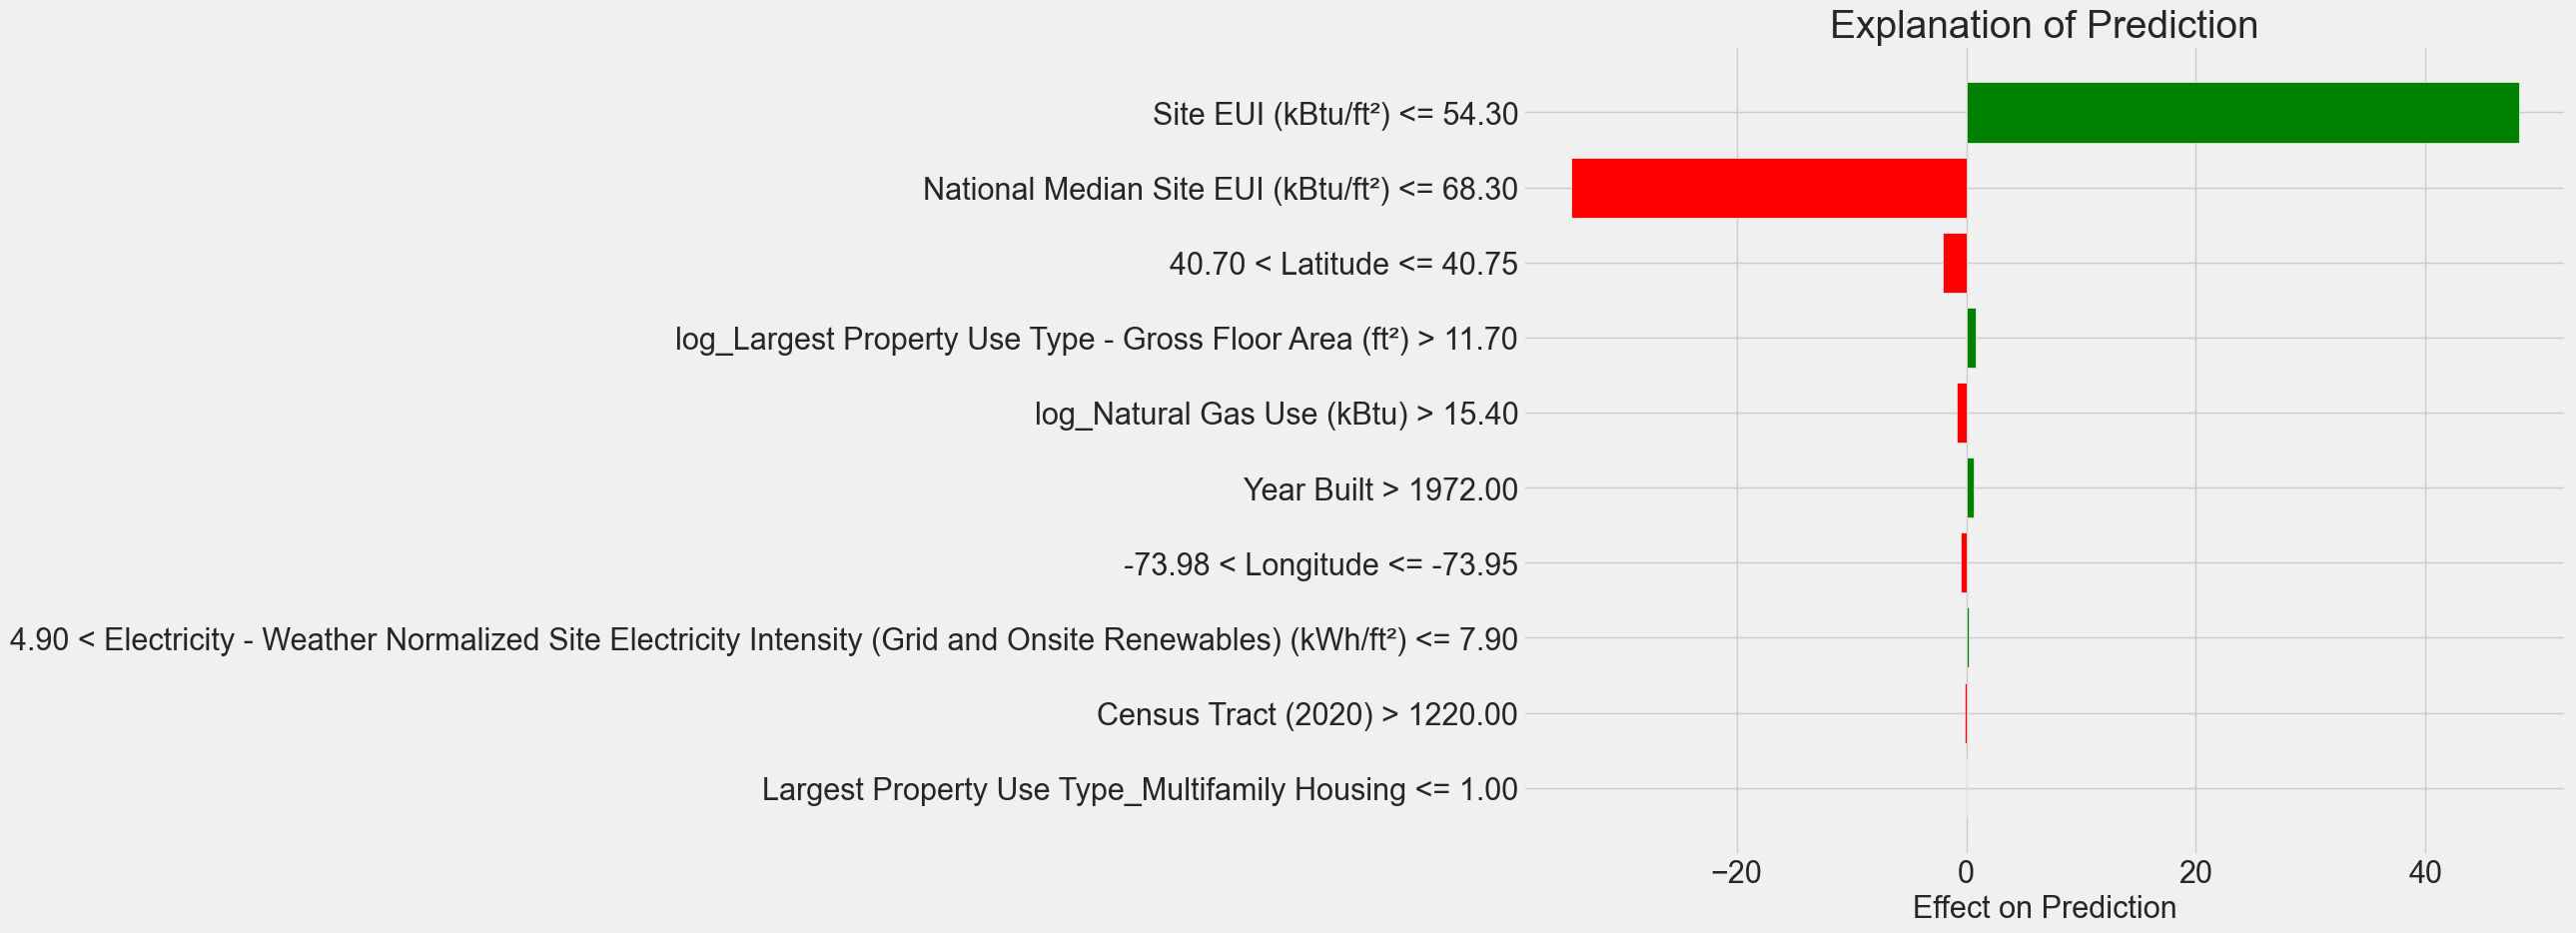

In [28]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In this example, our gradient boosted model predicted a score of 12.86 and the actual value was 100. 

The plot from LIME is showing us the contribution to the final prediction from each of the features for the example. We can see that the Site EUI singificantly decreased the prediction because it was above 95.50. The Weather Normalized Site Electricity Intensity on the other hand, increased the prediction because it was lower than 3.80. 

We can interpret this as saying that our model thought the Energy Star Score would be much lower than it actually was because the Site EUI was high. However, in this case, the score was 100 despite the high value of the EUI. While this significant mistake (off by 88 points!) might initially have been confusing, now we can see that in reality, the model was reasoning through the problem and just arrived at the incorrect value! A human going over the same process probably would have arrived at the same conclusion (if they had the patience to go through all the data). 

Now we can go through the same process with a prediction the model got correct.

Prediction: 100.0000
Actual Value: 100.0000


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_5264/2277720504.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))


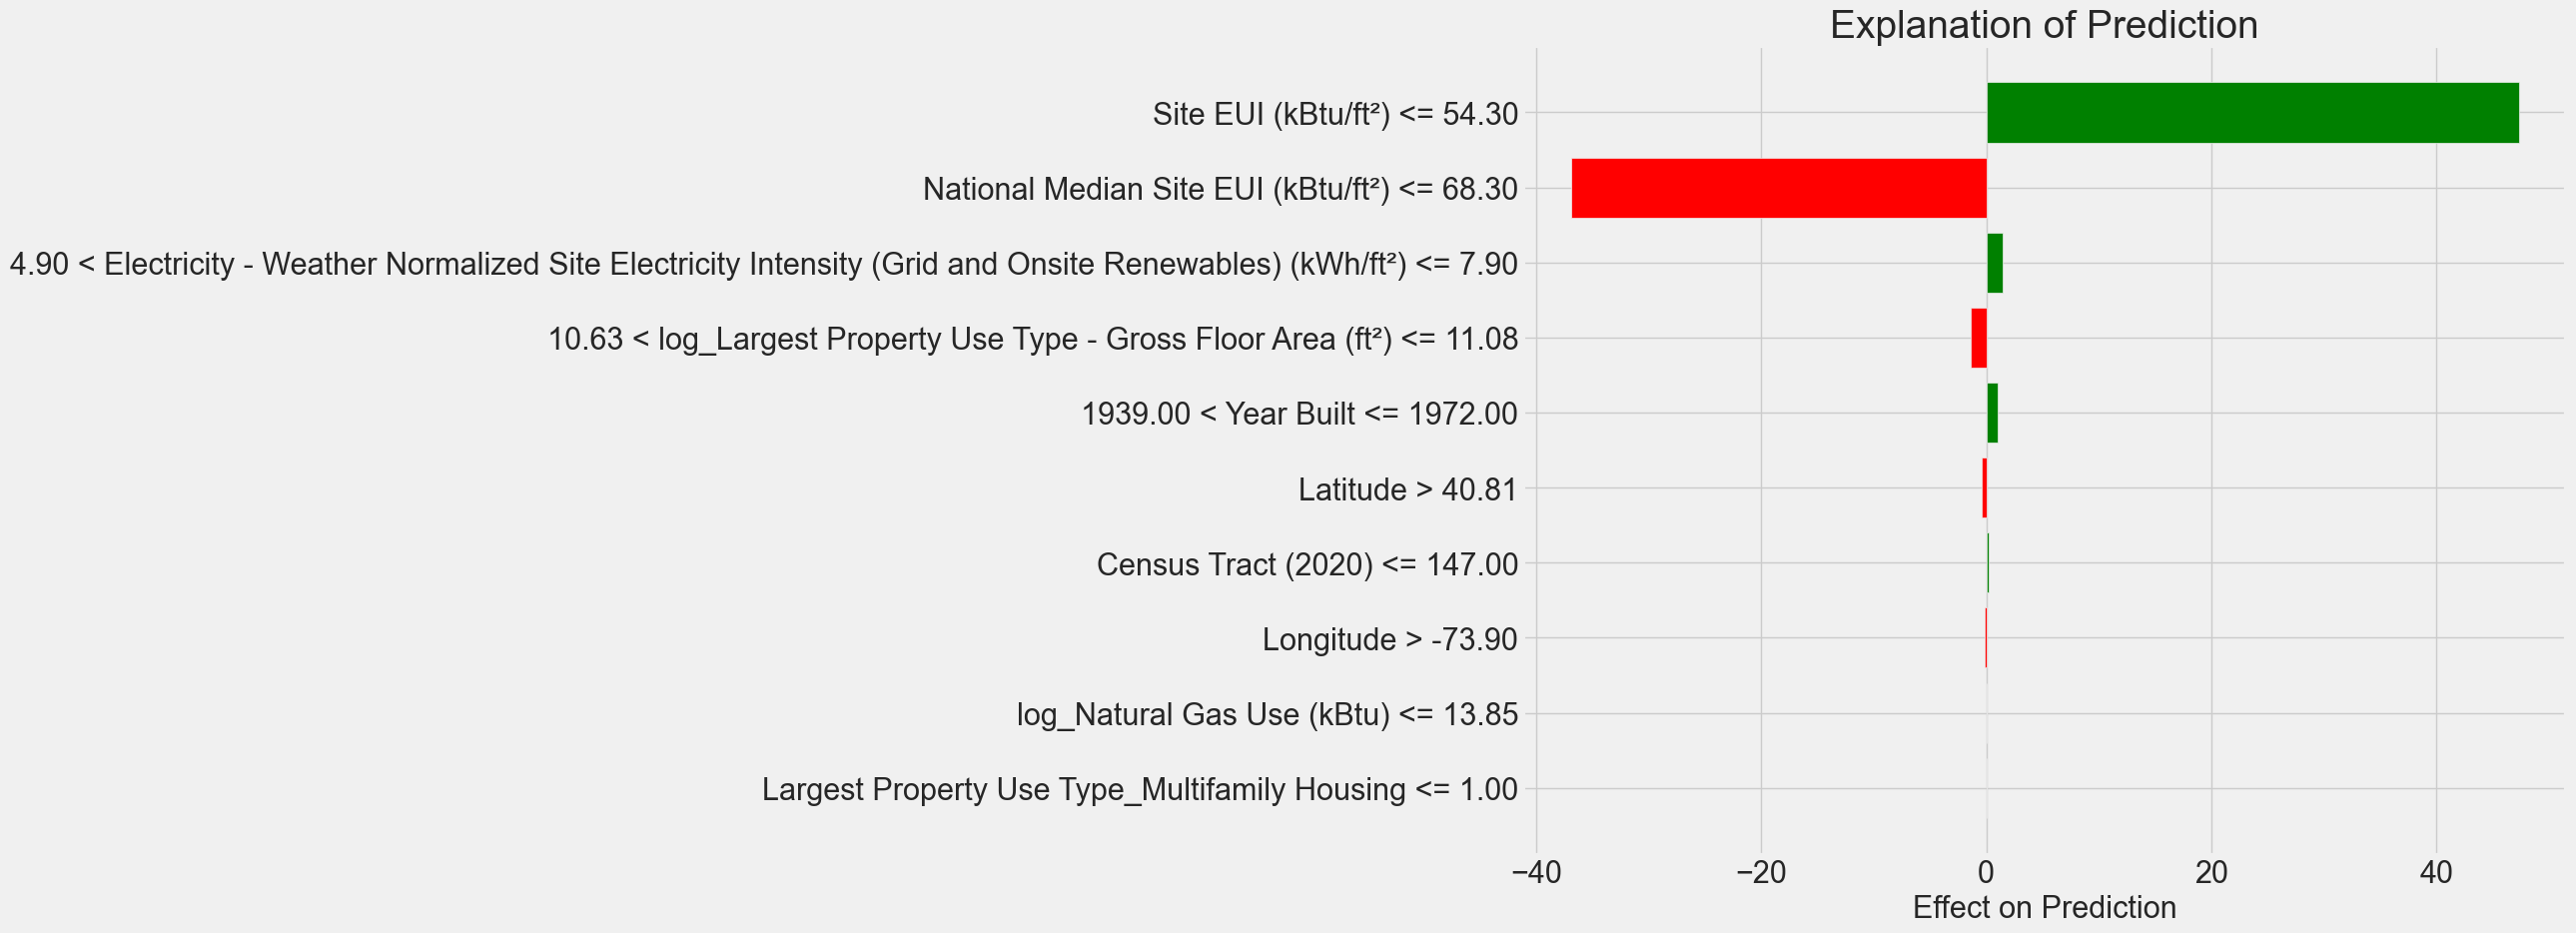

In [29]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

The correct value for this case was 100 which our gradient boosted model got right on! 

The plot from LIME again shows the contribution to the prediciton of each of feature variables for the example. For instance, because the Site EUI was less than 62.70, that contributed significantly to a higher estimate of the score. Likewise, the year built being less than 1927 also positively contributed to the final prediction. 

Observing break down plots like these allow us to get an idea of how the model makes a prediction. This is probably most valuable for cases where the model is off by a large amount as we can inspect the errors and perhaps engineer better features or adjust the hyperparameters of the model to improve predictions for next time. The examples where the model is off the most could also be interesting edge cases to look at manually. The model drastically underestimated the Energy Star Score for the first building because of the elevated Site EUI. We might therefore want to ask why the building has such a high Energy Star Score even though it has such a high EUI. A process such as this where we try to work with the machine learning algorithm to gain understanding of a problem seems much better than simply letting the model make predictions and completely trusting them! Although LIME is not perfect, it represents a step in the right direction towards explaining machine learning models. 

## Examining a Single Decision Tree

One of the coolest parts about a tree-based ensemble is that we can look at any individual estimator. Although our final model is composed of 800 decision trees, and looking at a single one is not indicative of the entire model, it still allows us to see the general idea of how a decision tree works. From there, it is a natural extension to imagine hundreds of these trees [building off the mistakes of previous trees](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d) to make a final prediction (this is a significant oversimplification of how [gradient boosting regression works!](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html))

We will first extract a tree from the forest and then save it using `sklearn.tree.export_graphviz`. This saves the tree as a `.dot` file which can be converted to a png using command line instructions in the Notebook.

In [30]:
import os
os.makedirs('../images', exist_ok=True)

# Extract a single tree from the ensemble
single_tree = model_reduced.estimators_[105][0]

# Export the tree to a .dot file for visualization (e.g., with Graphviz)
tree.export_graphviz(
    single_tree,
    out_file='../images/tree.dot',
    rounded=True,
    feature_names=most_important_features,
    filled=True
)

# Optional: display the tree object
single_tree


DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, min_samples_leaf=6,
                      min_samples_split=6,
                      random_state=RandomState(MT19937) at 0x168F95840)

In [34]:
import graphviz
from IPython.display import display

![image](../images/tree.dot)

That's one entire tree in our regressor of 800! It's a little difficult to make out because the maximum depth of the tree is 5. To improve the readability, we can limit the max depth in the call to export our tree.

![image](images/tree_small.dot)

Now we can take a look at the tree and try to intrepret it's decisions! The best way to think of a decision tree is as a series of yes/no questions, like a flowchart. We start at the top, called the root, and move our way down the tree, with the direction of travel determined by the answer to each equation.

For instance, here the first question we ask is: is the `Site EUI` less than or equal to 15.95? If the answer is yes, then we move to the left and ask the question: is the `Weather Normalized Site Electricity Intensity` less than or equal to 3.85? If the answer to the first question was no, we move to the right and ask the question is the `Weather Normalized Site Electricity Intensity` less than or equal to 26.85? 

We continue this iterative process until we reach the bottom of the tree and end up in a leaf node. Here, the value we predict corresponds to the value shown in the node (the values in this tree appear to be the actual predictions divided by 100). 

Each node has four different pieces of information:

1. The question: based on this answer we move right or left to the next node a layer down in the tree
2. The friedman_mse: a measure of the error for all of the examples in a given node
3. The samples: number of examples in a node
4. The value: the prediction of the target for all examples in a node

We can see that as we increase the depth of the tree, we will be better able to fit the data. With a small tree, there will be many examples in each leaf node, and because the model estimates the same value for each example in a node, there will probably be a larger error (unless all of the examples have the same target value). Constructing too large of a tree though can lead to overfitting. We can control a number of hyperparameters that determine the depth of the tree and the number of examples in each leaf. We saw how to select a few of these hyperaparameters in the second part when we performed optimimation using cross validation. 

Although we clearly cannot examine every tree in our model, looking at a single one does give us some idea how our model makes predictions. In fact, this flowchart based method seems much like how a human makes decisions, answering one question about a single value at a time. Decision tree based ensembles simply take the idea of a single decision tree and combine the predictions of many individuals in order to create a model with less variance than a single estimator. Ensembles of trees tend to be very accurate, and also are intuitive to explain! 

# Make Conclusions and Document Findings

The final part of the machine learning pipeline might be the most important: we need to compress everything we have learned into a short summary highlighting only the most crucial findings. Learning to extract the most important elements of data science or machine learning project is a crucial skill in communicating results in a concise way to a wide array of audiences.

Here are some conclusions from this project:

1. Using the given building energy data, a machine learning model can predict the Energy Star Score of a building to within 2 points. 
2. The most important variables for determining the Energy Star Score are the Energy Use Intensity, Electricity Use Intensity, and the Property Use.

If anyone asks for the details, then we can easily explain all the implementation steps, and present our well-documented work. Another crucial aspect of a machine learning project is that you have commented all your code and made it easy to follow! You want someone else (or yourself in a few months) to be able to look at your work and completely understand the decisions you made. Ideally you should write code with the intention that it will be used again. Even when we are doing projects by ourselves, it's good to practice proper documentation and it will make your life much easier when you want to revisit a project. 